# Image Deblurring - June Exam

### Dataset creation - DO NOT MODIFY

In [8]:
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Dense, MaxPooling2D, Add, Dropout, ConvLSTM2D, GaussianNoise, Bach
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

In [9]:
(x_train_blured, x_train), (x_test_blured, x_test) = getDataset()
print(f"Train size: {x_train_blured.shape}. Test size: {x_test_blured.shape}")

Train size: (50000, 32, 32, 3). Test size: (10000, 32, 32, 3)


In [10]:
from tensorflow.keras import layers

# ResBlock

def resblock(x, kernelsize, filters):
    fx = layers.Conv2D(filters, kernelsize, activation='relu', padding='same')(x)
    fx = layers.ReLU()(fx)
    fx = layers.Conv2D(filters, kernelsize, padding='same')(fx)
    out = layers.Add()([x,fx])
    return out

In [11]:
# input
input_shape = (32, 32, 3)
inputs = Input(shape=input_shape)

# encoding

resblock_num = 3

# convolution + layers of resblocks

x = Conv2D(64, (2, 2), strides = 1, padding = 'same') (inputs)
for i in range(resblock_num):
  x = resblock(x, (2, 2), 64)
res_1 = resblock(x, (2, 2), 64)
x = MaxPooling2D(pool_size=(2, 2), strides=2) (res_1)
x = GaussianNoise(0.05) (x)
x = Conv2D(32, (2, 2), strides = 1, padding = 'same') (x)
for i in range(resblock_num):
  x = resblock(x, (2, 2), 32)
res_2 = resblock(x, (2, 2), 32)
x = MaxPooling2D(pool_size=(2, 2), strides=2) (res_2)
x = GaussianNoise(0.05) (x)
x = Conv2D(16, (2, 2), strides = 1, padding = 'same') (x)
for i in range(resblock_num):
  x = resblock(x, (2, 2), 16)

# hidden layer

x = Conv2D(8, (2, 2), strides = 1, padding = 'same') (x)
x = tf.expand_dims(x, 1)

# recurrent layer 

rl_1 = ConvLSTM2D(8, (2, 2), strides = 1, padding = 'same', dropout = 0.2, return_sequences=True) (x)
x = tf.squeeze(rl_1, 1)
x = Conv2D(8, (2, 2), strides = 1, padding = 'same') (x)

# decode
x = Conv2DTranspose(16, (2, 2), strides = 1, padding = 'same') (x)
for i in range(resblock_num):
  x = resblock(x, (2, 2), 16)
x = Conv2DTranspose(16, (2, 2), strides = 1, padding = 'same') (x)

x = Conv2DTranspose(32, (2, 2), strides = 2, padding = 'same') (x)
z = Add()([x, res_2])
for i in range(resblock_num):
  x = resblock(z, (2, 2), 32)
x = Conv2DTranspose(32, (3, 3), strides = 1, padding = 'same') (x)

x = Conv2DTranspose(64, (2, 2), strides = 2, padding = 'same') (x)
z = Add()([x, res_1])
for i in range(resblock_num):
  x = resblock(z, (2, 2), 64)
x = Conv2DTranspose(64, (2, 2), strides = 1, padding = 'same') (x)
outputs = Conv2DTranspose(3, (1, 1), strides = 1, activation = 'sigmoid', padding = 'same') (x)

# secondo layer

x = Conv2D(64, (2, 2), strides = 1, padding = 'same') (outputs)
for i in range(resblock_num):
  x = resblock(x, (2, 2), 64)
res_3 = resblock(x, (2, 2), 64)
x = MaxPooling2D(pool_size=(2, 2), strides=2) (res_3)
x = GaussianNoise(0.05) (x)
x = Conv2D(32, (2, 2), strides = 1, padding = 'same') (x)
for i in range(resblock_num):
  x = resblock(x, (2, 2), 32)
res_4 = resblock(x, (2, 2), 32)
x = MaxPooling2D(pool_size=(2, 2), strides=2) (res_4)
x = GaussianNoise(0.05) (x)
x = Conv2D(16, (2, 2), strides = 1, padding = 'same') (x)
for i in range(resblock_num):
  x = resblock(x, (2, 2), 16)

# hidden layer

x = Conv2D(8, (2, 2), strides = 1, padding = 'same') (x)
x = tf.expand_dims(x, 1)

z = Add()([x, rl_1])
rl_2 = ConvLSTM2D(8, (2, 2), strides = 1, padding = 'same', dropout = 0.2) (z)
x = Conv2D(8, (2, 2), strides = 1, padding = 'same') (rl_2)

# decode
x = Conv2DTranspose(16, (2, 2), strides = 1, padding = 'same') (x)
for i in range(resblock_num):
  x = resblock(x, (2, 2), 16)
x = Conv2DTranspose(16, (2, 2), strides = 1, padding = 'same') (x)

x = Conv2DTranspose(32, (2, 2), strides = 2, padding = 'same') (x)
z = Add()([x, res_2])
for i in range(resblock_num):
  x = resblock(z, (2, 2), 32)
x = Conv2DTranspose(32, (3, 3), strides = 1, padding = 'same') (x)

x = Conv2DTranspose(64, (2, 2), strides = 2, padding = 'same') (x)
z = Add()([x, res_1])
for i in range(resblock_num):
  x = resblock(z, (2, 2), 64)
x = Conv2DTranspose(64, (2, 2), strides = 1, padding = 'same') (x)
outputs = Conv2DTranspose(3, (1, 1), strides = 1, activation = 'sigmoid', padding = 'same') (x)

# model creation
model = Model(inputs=inputs,outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_90 (Conv2D)             (None, 32, 32, 64)   832         ['input_2[0][0]']                
                                                                                                  
 conv2d_91 (Conv2D)             (None, 32, 32, 64)   16448       ['conv2d_90[0][0]']              
                                                                                                  
 re_lu_40 (ReLU)                (None, 32, 32, 64)   0           ['conv2d_91[0][0]']              
                                                                                            

In [12]:
adam_optimizer = Adam(learning_rate=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(loss = 'mse', optimizer = adam_optimizer,metrics=["mae", "acc"])

In [18]:
hist = model.fit(x_train_blured.reshape(-1, 32, 32, 3), 
          x_train.reshape(-1, 32, 32, 3), 
          epochs = 15, 
          batch_size = 200, 
          validation_split=0.1)

Epoch 1/15
225/225 [==============================] - 58s 258ms/step - loss: 0.0039 - mae: 0.0443 - acc: 0.8344 - val_loss: 0.0038 - val_mae: 0.0436 - val_acc: 0.8392
Epoch 2/15
225/225 [==============================] - 58s 257ms/step - loss: 0.0039 - mae: 0.0441 - acc: 0.8349 - val_loss: 0.0038 - val_mae: 0.0434 - val_acc: 0.8403
Epoch 3/15
225/225 [==============================] - 58s 257ms/step - loss: 0.0038 - mae: 0.0439 - acc: 0.8349 - val_loss: 0.0038 - val_mae: 0.0435 - val_acc: 0.8379
Epoch 4/15
225/225 [==============================] - 58s 258ms/step - loss: 0.0038 - mae: 0.0436 - acc: 0.8348 - val_loss: 0.0037 - val_mae: 0.0430 - val_acc: 0.8374
Epoch 5/15
225/225 [==============================] - 58s 257ms/step - loss: 0.0038 - mae: 0.0434 - acc: 0.8350 - val_loss: 0.0037 - val_mae: 0.0428 - val_acc: 0.8382
Epoch 6/15
225/225 [==============================] - 58s 258ms/step - loss: 0.0037 - mae: 0.0432 - acc: 0.8350 - val_loss: 0.0036 - val_mae: 0.0425 - val_acc: 0.836

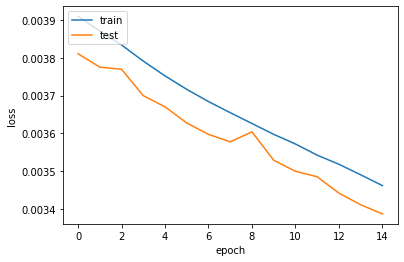

In [19]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(hist,['loss','val_loss'])

In [20]:
predictions = model.predict(x_test_blured)

In [21]:
predictions.shape

(10000, 32, 32, 3)

In [22]:
from tensorflow.keras.losses import MeanSquaredError

y_true = x_test
y_pred = predictions

mse = MeanSquaredError()
mse(y_true, y_pred).numpy()

#0.0023

#0.0041738243220982366
#0.004219622105503972
#0.00404854369862134
#0.003909846398674108
#0.00379532259022029
#0.003393252

0.003393252

Original Images


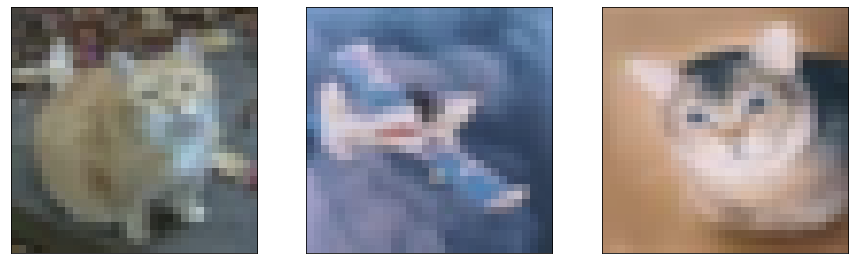

Blurred Images


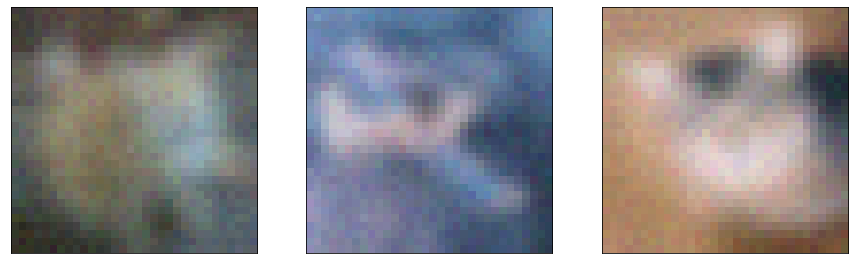

Predicted Images


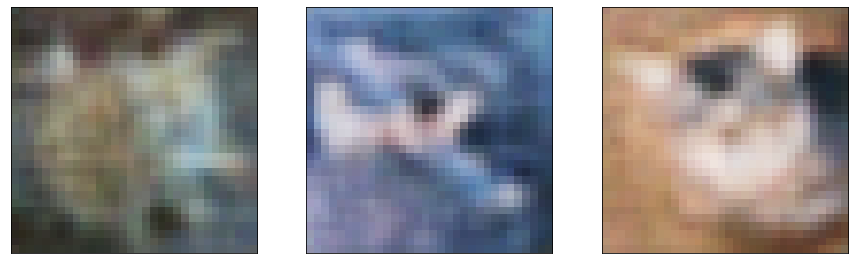

In [ ]:
#utility function to pick samples to be tested

def get_samples(arr, n):
    temp = random.sample(range(len(arr)), n)
    result = arr[temp]
    return result, temp

num = 3
figsize = 15
org, temp = get_samples(x_test, num)
blur = x_test_blured[temp]
preds = model.predict(blur.reshape(-1, 32, 32, 3))
#plotting results
plt.figure(figsize = (figsize, figsize))
print('Original Images')
for i in range(num):
    plt.subplot(1, num, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(org[i])
plt.show()
plt.figure(figsize = (figsize, figsize))
print('Blurred Images')
for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(blur[i])
plt.show()
plt.figure(figsize = (figsize, figsize))
print('Predicted Images')
for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(preds[i])
plt.show()

SOLUZIONE 2

In [ ]:
from keras.layers import Input
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.layers.core import Dense, Flatten
from keras.layers import BatchNormalization
from keras.models import Model


from keras.layers import Input, Activation, Add
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.core import Lambda
from keras.models import Model

ndf = 64
ngf = 64
n_blocks_gen = 9
output_nc = 3
input_shape_discriminator = (32, 32, output_nc)

inputs = Input(shape=(32, 32, 3))

x = Conv2D(filters=ngf, kernel_size=(7,7), padding='valid')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Increase filter number
n_downsampling = 2
for i in range(n_downsampling):
    mult = 2**i
    x = Conv2D(filters=ngf*mult*2, kernel_size=(3,3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

# Apply 9 ResNet blocks
mult = 2**n_downsampling
for i in range(n_blocks_gen):
    pass
    # x = res_block(x, ngf*mult, use_dropout=True)

# Decrease filter number to 3 (RGB)
for i in range(n_downsampling):
    mult = 2**(n_downsampling - i)
    x = Conv2DTranspose(filters=int(ngf * mult / 2), kernel_size=(2, 2), strides=3-i, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

x = Conv2D(filters=32, kernel_size=(7,7), padding='valid')(x)
x = Conv2D(filters=64, kernel_size=(5,5), padding='valid')(x)
x = Conv2D(filters=output_nc, kernel_size=(1,1), padding='valid')(x)

x = Activation('tanh')(x)

# Add direct connection from input to output and recenter to [-1, 1]
# outputs = Add()([x, inputs])
# outputs = Lambda(lambda z: z/2)(x)

x = Conv2D(8, (2, 2), strides = 1, padding = 'same') (x)
#decode
x = Conv2DTranspose(16, (2, 2), strides = 1, padding = 'same') (x)
x = Conv2DTranspose(32, (2, 2), strides = 1, padding = 'same') (x)
x = Conv2DTranspose(64, (2, 2), strides = 1, padding = 'same') (x)
outputs = Conv2DTranspose(3, (1, 1), strides = 1, activation = 'sigmoid', padding = 'same') (x)
model = Model(inputs=inputs, outputs=outputs, name='Generator')
model.summary()

In [ ]:
# modello iniziale 0.0055

#encode
inputs = Input(shape=(32, 32, 3))

x = Conv2D(64, (2, 2), strides = 1, padding = 'same') (inputs)
x = Conv2D(32, (2, 2), strides = 1, padding = 'same') (x)
x = MaxPooling2D(pool_size=(2, 2), strides=2) (x)

x = Conv2D(16, (2, 2), strides = 1, padding = 'same') (x)
#latent
x = Conv2D(16, (2, 2), strides = 1, padding = 'same') (x)
x = Dense(16, activation='relu')(x)
x = Conv2D(8, (2, 2), strides = 1, padding = 'same') (x)
x = Dense(16, activation='relu')(x)
x = Conv2D(16, (2, 2), strides = 1, padding = 'same') (x)
#decode
x = Conv2DTranspose(16, (2, 2), strides = 2, padding = 'same') (x)
x = Conv2DTranspose(32, (3, 3), strides = 1, padding = 'same') (x)
x = Conv2DTranspose(64, (2, 2), strides = 1, padding = 'same') (x)
outputs = Conv2DTranspose(3, (1, 1), strides = 1, activation = 'sigmoid', padding = 'same') (x)

# model = Model(inputs=inputs,outputs=outputs)
# model.summary()

In [ ]:
# adam_optimizer = Adam(learning_rate=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(loss = 'mse', optimizer = 'adam')
hist = model.fit(x_train_blured.reshape(-1, 32, 32, 3), 
          x_train.reshape(-1, 32, 32, 3), 
          epochs = 10, 
          batch_size = 200, 
          validation_data = (x_val_blured.reshape(-1, 32, 32, 3), x_val.reshape(-1, 32, 32, 3)))

In [ ]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(hist,['loss','val_loss'])